# OOGESO - example case
Representing a hypothetical, but realistic offshore oil and gas platform with production rates

* crude oil: 50 Sm3/s, of which:
    * gas: 49.75 Sm3/s = 4.3 mill Sm3/day 
    * oil:  0.1 Sm3/s = 8640 Sm3/day  
    * water: 0.15 Sm3/s = 12960 Sm3/day 

Units:
* Flow is in Sm3/s
* Electric and heat power is in MW

### Notes
Pipe diameters may be estimated based on flow rate and typical flow velocity: 
$Q=\frac{\pi d^2}{4}v \Rightarrow d=\sqrt{\frac{4Q}{\pi v}}$  

Gas velocity dependence on pressure:
* Ideal gas: $\frac{pV}{T}=const \Rightarrow V=V_0\frac{p_0}{p}\frac{T}{T_0}$.
* Steady-state, constant diameter: $V = Av\Delta t \Rightarrow v = v_0 \frac{p_0}{p}\frac{T}{T_0}, Q = Q_0 \frac{p_0}{p}\frac{T}{T_0}$
* For $p=10$ MPa, $p_0=0.1$ MPa, $T=T_0$ $\Rightarrow$ $v = v_0/100,Q = Q_0/100$ 

Flow velocities 
* ref: 1) https://petrowiki.org/Pipeline_design_consideration_and_standards#Velocity_considerations, 2) https://intech-gmbh.com/pipelines_calc_and_select/
* gas: $v$=15 m/s
    * Q=50 Sm3/s, p=10 MPa $\Rightarrow$ Q=0.5 m3/s, d=<ins>0.206 m</ins>
* oil: $v$=2.5 m/s (assuming incompressible, so flow rate unchanged by pressure)
    * Q=0.1 m/s $\Rightarrow$ d= <ins>0.226m </ins>
* wellstream: ? (high gas to oil ratio (GOR))
    *


Viscosity: 
* "Typical oil viscosities range from 0.1 cp for near-critical oils to >100 cp for heavy crudes" (1 cp = 0.001 Pa s) 
* wellstream ("black oil" GOR ca 500): viscosity $\mu$= 0.3 cp = 3e-4 Pa s
    * ref: http://www.ipt.ntnu.no/~curtis/courses/PhD-PVT/PVT-HOT-Vienna-May-2016x/e-notes/PVT-Papers/SPEPBM-Ch3.pdf (fig 3.4 and 3.5)

Gas to oil ratio (GOR):
* volume of gas divided by volume of oil at standard condition, i.e.
```python
comp=carrier_properties['wellstream']['composition']
GOR = comp['gas']/comp['oil'] 
```
* GOR $\approx$ 500 in our case

### TODO
* specify pressure deviation limits per node (not globally)
* remove generic Pdev variable (use instead device specific varaibles, e.g. terminal in/out flow
* replace Pmax, Pmin constraints by device model specific constraints

In [35]:
#diameter:
#np.sqrt(4*50/100/(np.pi*15)),np.sqrt(4*0.1/(np.pi*2.5)),
#GOR:
#0.995/0.002
#flowrate oil:
np.sqrt(np.pi**2*0.2**5/(2*0.02*900*5000))*np.sqrt(0.5e6)

0.09366419641387635

In [37]:
%load_ext autoreload
%autoreload 2
from oogeso import multicarrier
from oogeso import plots
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
outpath = "result_example2/"

# 1 oil barrel = 0.158987 m3
# 1 $/barrel = 8.4 $/m3
# 50 $/barrel = 419 $ /m3
carrier_properties = {
    'wellstream': {
            'composition': {'gas':0.995, 'oil':0.002, 'water':0.003}, #Sm3
            'rho_density': 5.63, # kg/Sm3 - computed from composition and densities of gas/oil/water
            'viscosity': 0.001, #kg/(m s) - assuming quite light crude (lot of gas)
            },
    'water': {'rho_density': 1000, # kg/Sm3},
              'viscosity': 0.001, #kg/(m s)
             },
    'oil': {'export_price': 419, #EUR/Sm3
            'rho_density': 900, # kg/Sm3,
            'viscosity':0.0026, #kg/(m s)
            'darcy_friction': 0.02
            #'energy_value':36000, #MJ/Sm3
            #'CO2content':260 #kg/MWh
            },
    'gas':{'energy_value':40, #MJ/Sm3
           'rho_density': 0.84, # kg/Sm3
           'CO2content':2.34, #kg/Sm3, SSB 2016 report
           'export_price': 0.419, #$/Sm3
           'Tb_basetemp_K':273+15,
           'Pb_basepressure_MPa':0.101,
           'G_gravity':0.6,
           'Z_compressibility':0.9,
           'k_heat_capacity_ratio':1.27,
           'R_individual_gas_constant': 500, # J/kg K
           }, 
    'el':{'energy_value':1,
          #'CO2content':0,
          'export_price': 50, #EUR/MWh
          },
    'heat':{#'CO2content':0
            },
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2020-06-12 15:16:29 INFO: TODO: objective function definition
2020-06-12 15:16:29 INFO: TODO: separator power (eta) and heat (eta2) demand
2020-06-12 15:16:29 INFO: Compressor - output pressure fixed at nominal value?
2020-06-12 15:16:29 INFO: TODO: gas turbine power vs heat output
2020-06-12 15:16:29 INFO: TODO: startup cost
2020-06-12 15:16:29 INFO: TODO: el source: dieselgen, fuel, on-off variables
2020-06-12 15:16:29 INFO: TODO: liquid pump approximation ok?
2020-06-12 15:16:29 INFO: TODO: flow vs pressure equations for liquid flows


TODO: startup delay does not work with Pmin>0


2020-06-12 15:16:29 WARNING: Element export_node already exists in set setParameters; no action taken.
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:

    taken.


2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635
2020-06-12 15:16:30 INFO: flow rate: nominal=None, linearQ0=0.09366419641387635


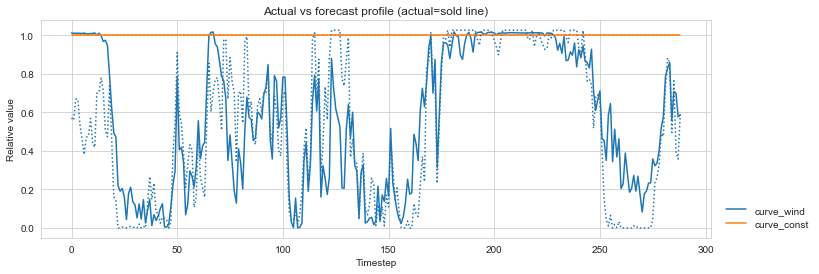

In [39]:
mc = multicarrier.Multicarrier(loglevel="INFO",quadraticConstraints=False)
data,profiles = multicarrier.read_data_from_xlsx("data_example2.xlsx", carrier_properties)
#data['paramDeviceEnergyInitially'][17]=2.5 # MWh - battery
for dev in ['Gen1','Gen2']:
    data['paramDeviceOnTimestepsInitially'][dev] = 10
    data['paramDeviceIsOnInitially'][dev] = 1
instance = mc.createModelInstance(data,profiles)
#print("Writing instance to file.")
#instance.pprint(outpath+"problem_instance.txt")
plots.plotProfiles(profiles,filename=None)

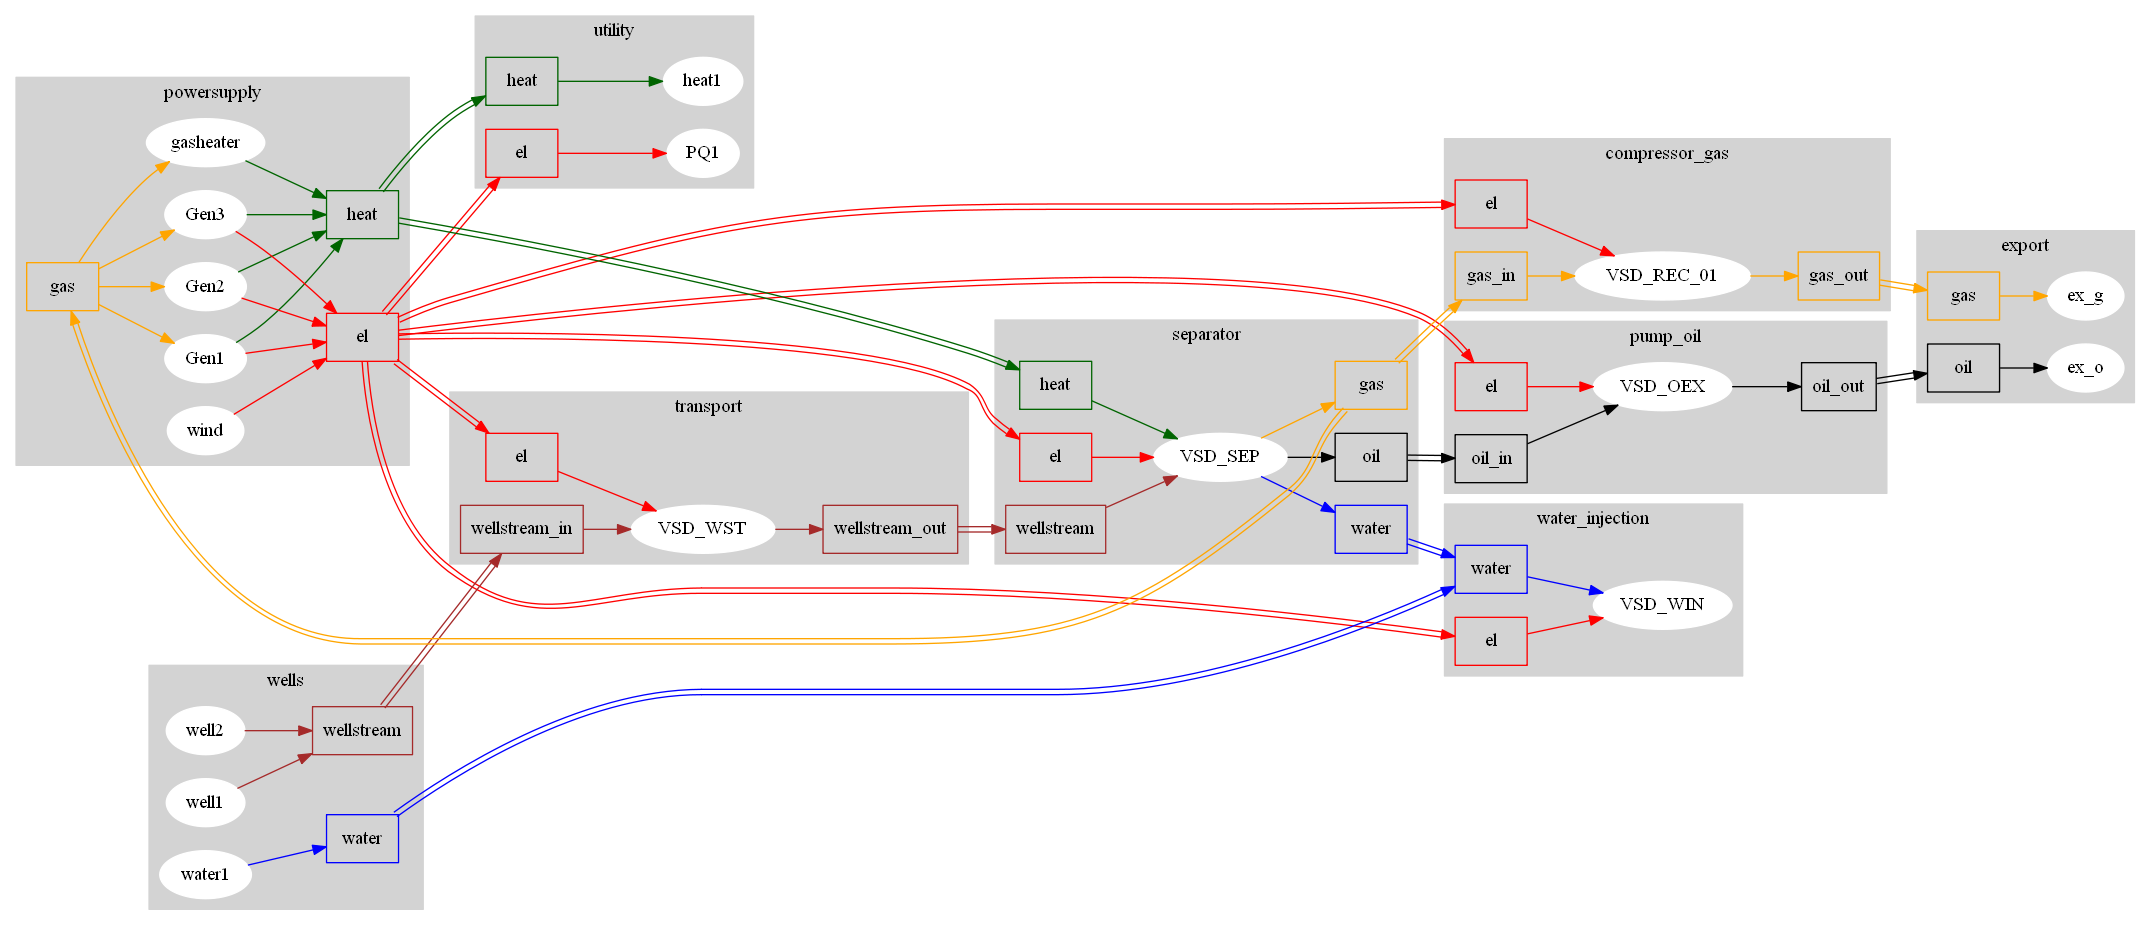

In [40]:
dotG=plots.plotNetwork(mc,timestep=None,filename=None)
#IPython.display.SVG(dotG.create_svg()) #original size, vector graphics
IPython.display.Image(dotG.create_png()) #scales automatically to page width

## Solve

In [41]:
status = mc.solveMany(solver="cbc",timerange=[0,40],write_yaml=False,timelimit=60)

# Save results to file:
#mc.exportSimulationResult(filename=outpath+"simresult.xlsx")

sumCO2 = mc._dfCO2rate.mean()
co2intensity = mc._dfCO2intensity.mean()
exportrevenue = mc._dfExportRevenue.mean()
print("Mean CO2 emission rate      = {:.1f} kgCO2/s".format(sumCO2))
print("Mean CO2 emission intensity = {:.1f} kgCO2/Sm3oe".format(co2intensity))
print("Mean export revenue         =",*["{}:{:.1f} ".format(x,v) for x,v in mc._dfExportRevenue.mean().items() if v!=0],"$/s")

2020-06-12 15:16:41 INFO: Using solver timelimit=60
2020-06-12 15:16:41 INFO: Solving timestep=0
2020-06-12 15:16:43 INFO: Solving timestep=6
2020-06-12 15:16:45 INFO: Solving timestep=12
2020-06-12 15:16:51 INFO: Solving timestep=18
2020-06-12 15:16:54 INFO: Solving timestep=24
2020-06-12 15:16:55 INFO: Solving timestep=30
2020-06-12 15:16:56 INFO: Solving timestep=36


Mean CO2 emission rate      = 7.0 kgCO2/s
Mean CO2 emission intensity = 48.0 kgCO2/Sm3oe
Mean export revenue         = oil:41.9  gas:19.6  $/s


## Analyse results

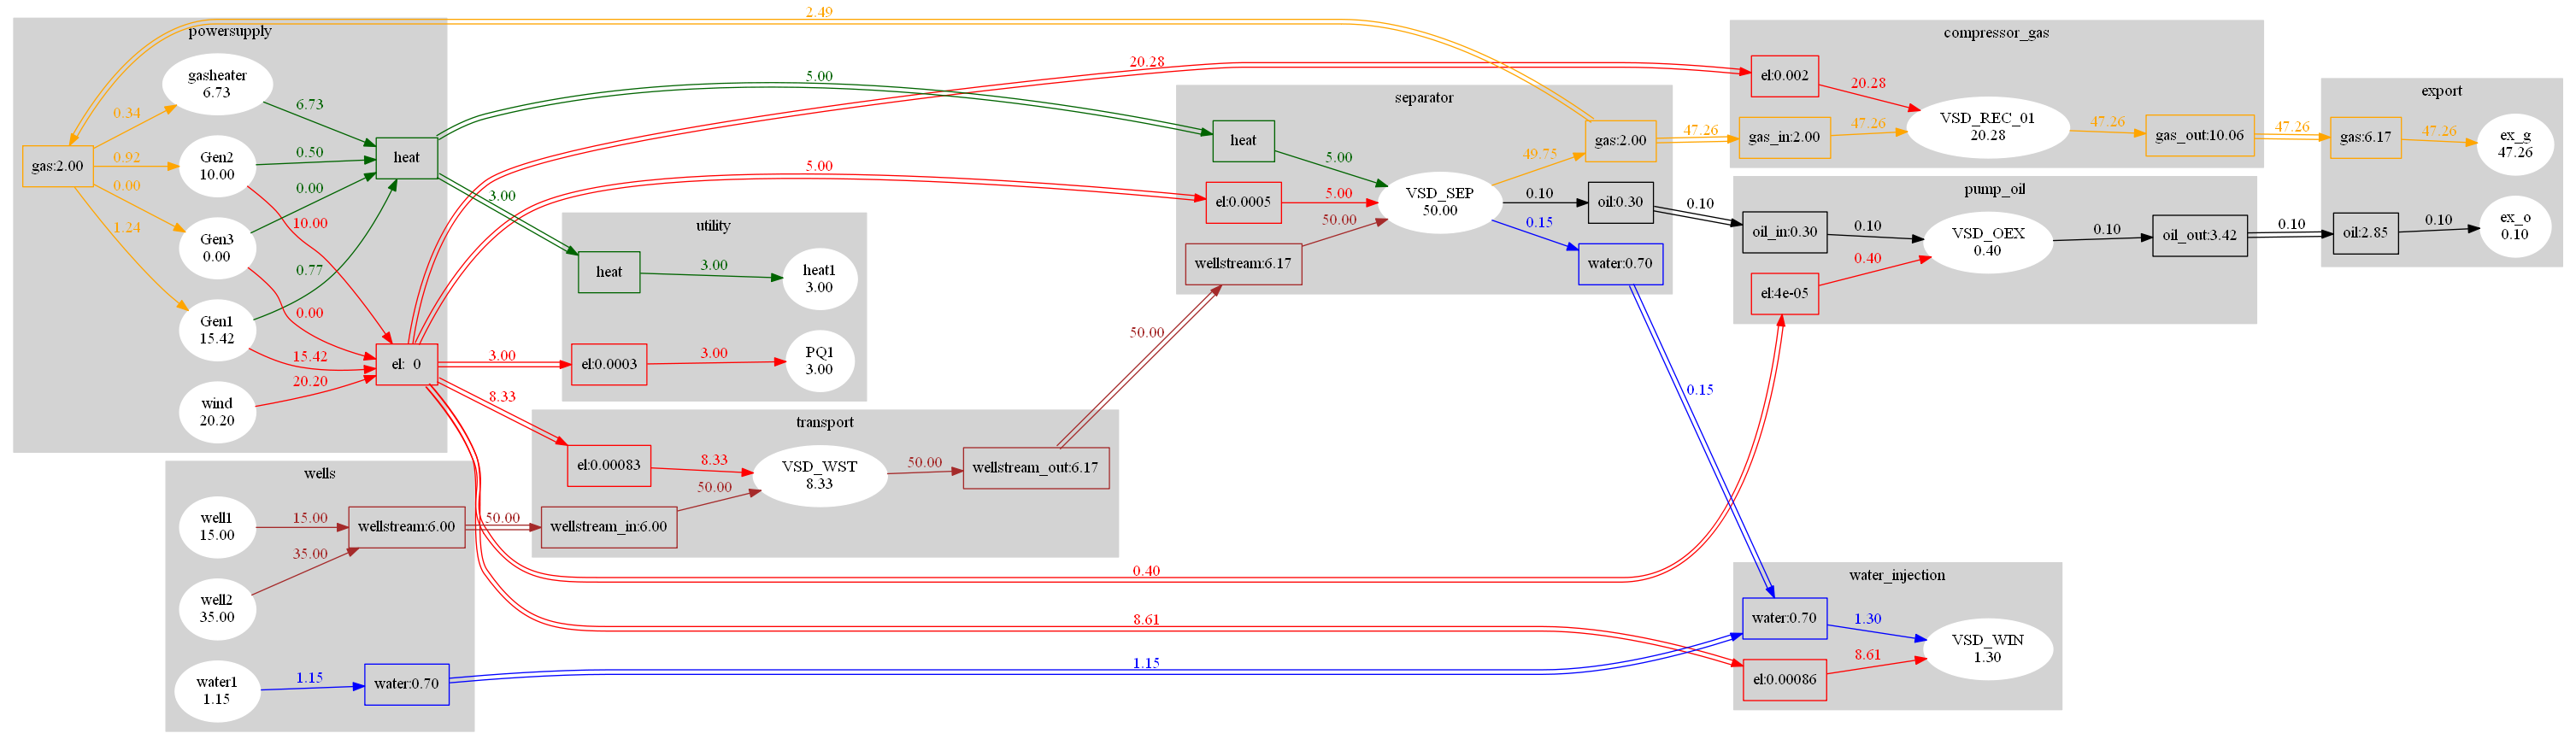

In [42]:
tstep=1
gCombined = plots.plotNetwork(mc,timestep=tstep,filename=outpath+"network_combined.png")
#gEl = plots.plotNetwork(mc,timestep=tstep,only_carrier='el')
#gHeat = plots.plotNetwork(mc,timestep=tstep,only_carrier='heat')
#gGas = plots.plotNetwork(mc,timestep=tstep,only_carrier='gas')
#gOil = plots.plotNetwork(mc,timestep=tstep,only_carrier='oil')
#gWater = plots.plotNetwork(mc,timestep=tstep,only_carrier='water')
IPython.display.Image(gCombined.create_png())

Notes to figure:
* Electrical power going into separator - Is this already included in the gas re-compression?
* Oil export pump power demand turns out very small (0.3 MW) for flow 0.1 Sm3/s and pressure increase from 0.3 to 3 MPa - is this realistic?

In [43]:
print("CHECKING nominal pressure values at t={}".format(tstep))
#mc.computeEdgePressureDrop(tstep)
mc.checkEdgePressureDrop(tstep)

CHECKING nominal pressure values at t=1
wellstream edge 7:wells-transport (Q=50.0 m3/s)
	Reynolds=8.96e+05, Darcy friction f=0.0121
	Reynolds=8.96e+05, Darcy friction f=0.0121
	NOMINAL:    pin=6.0  pout=6.0  pout_computed=-4.7671
	SIMULATION: pin=6.0  pout=6.0  pout_computed=-4.7671
	flow velocity = 1591.5 m/s
wellstream edge 8:transport-separator (Q=50.0 m3/s)
	Reynolds=8.96e+05, Darcy friction f=0.0121
	Reynolds=8.96e+05, Darcy friction f=0.0121
	NOMINAL:    pin=6.5  pout=6.5  pout_computed=-101.17
	SIMULATION: pin=6.175  pout=6.175  pout_computed=-101.5
	flow velocity = 1591.5 m/s
water edge 9:wells-water_injection (Q=1.15 m3/s)
	Reynolds=7.32e+06, Darcy friction f=0.0087
	Reynolds=7.32e+06, Darcy friction f=0.0087
	NOMINAL:    pin=nan  pout=0.7  pout_computed=nan
	SIMULATION: pin=0.7  pout=0.7  pout_computed=-232.46
	flow velocity = 146.42 m/s
oil edge 10:separator-pump_oil (Q=0.1 m3/s)
	Reynolds=1.1e+05, Darcy friction f=0.0178
	Reynolds=1.1e+05, Darcy friction f=0.0178
	NOMINAL: 

Notes to the above computed edge flows:  
* velocity of wellstream transport is very high.But it is not an incompressible liquid, so the density is not fixed (should be higher as the pressure is high)
    * compressibility $\rho = \rho_b\exp[c(p-p_b)]$; $p_b,\rho_b$ is pressure and density at XX. $c$ is the compressibility
    * " Density of reservoir oil varies from 30 lbm/ft3 for light volatile oils to 60 lbm/ft3 for heavy crudes with little or no solution gas. (480-961 kg/m3) 
    * "Oil compressibility may range from 3e6 psi^-1 for heavy crude oils to 50e6 psi^-1 for light oils. " (1 psi = 6894.76 Pa) => c = 438/Pa - 7251/Pa
    * p_b=0.1 MPa, rho_b=5.6 kg/m3 (cf above), c=6000/Pa, p=6 MPa => rho=OVERFLOW ERROR
* pressure drop for oil pipelines is very large 14 MPa/5km / 0.03 MPa/0.1km - and flow velocity (13 m/s) is probably too high **--improved by using 200mm instead of 100mm pipes: 3.1 m/s and 0.5 MPa/5km, 0.001MPa/0.1km**
* Clearly ERROR in wellstream and water pipe pressure drop computations

In [95]:
50/6894.76,5.6*np.exp(6e-6*(6-0.1)*1e6)

(0.007251884039473455, 1.3249902618133818e+16)

In [89]:
instance.paramCarriers['oil']
#instance.paramEdge[15]
mc.compute_edge_pressuredrop(instance,edge=15,t=4,Q=30)

	Reynolds=3.31e+07, Darcy friction f=0.00707


-18116.741919216744

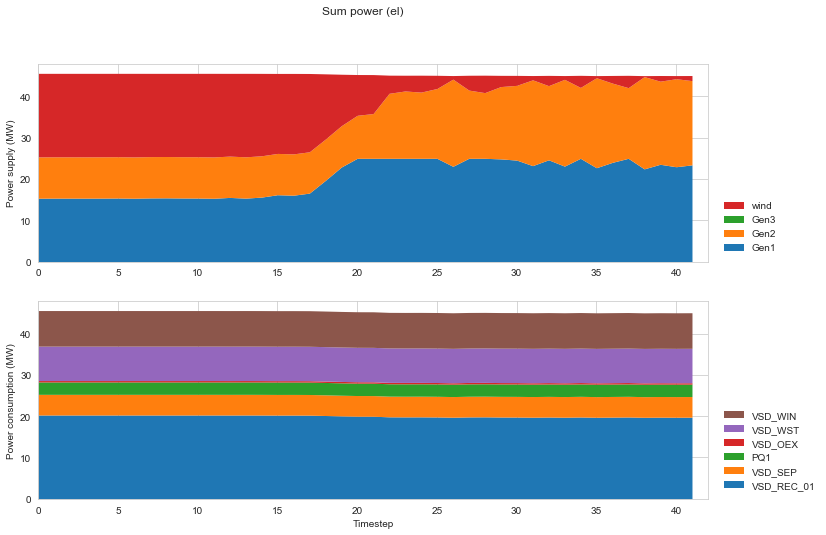

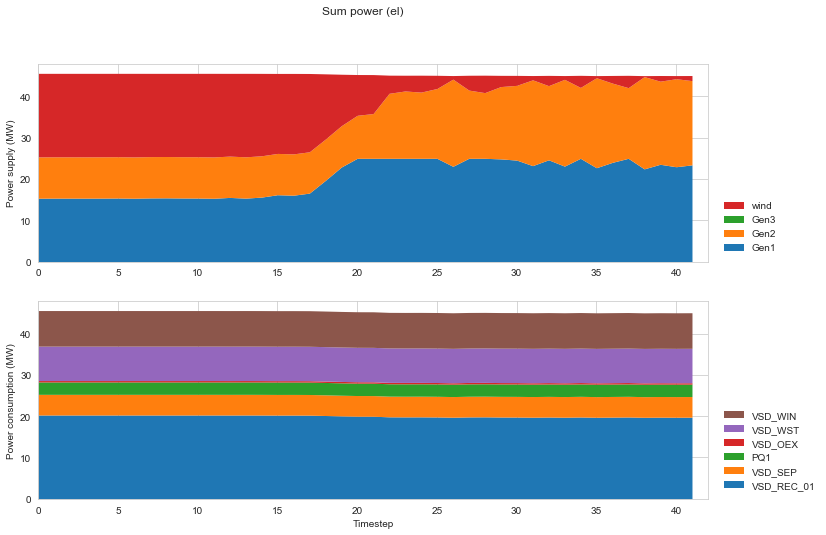

In [90]:
#plots.plot_SumPowerMix(mc,carrier="el",filename=outpath+"el_sum_opt.png")
plots.plot_SumPowerMix(mc,carrier="el",filename=None)

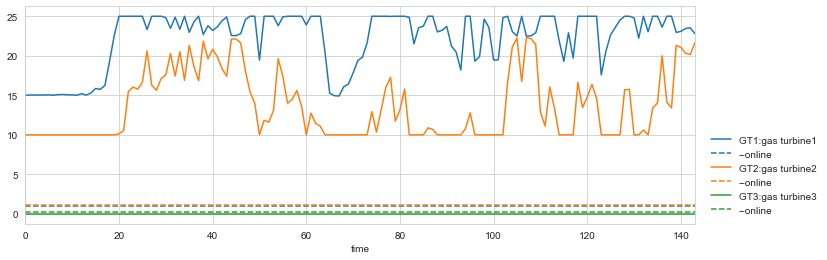

In [23]:
gts = [d for d in mc.instance.setDevice 
       if mc.instance.paramDevice[d]['model']=='gasturbine']
#plots.plot_deviceprofile(mc,devs=gts,profiles=profiles,filename=outpath+"GTs_opt.png")
plots.plot_deviceprofile(mc,devs=gts,profiles=profiles,filename=None)


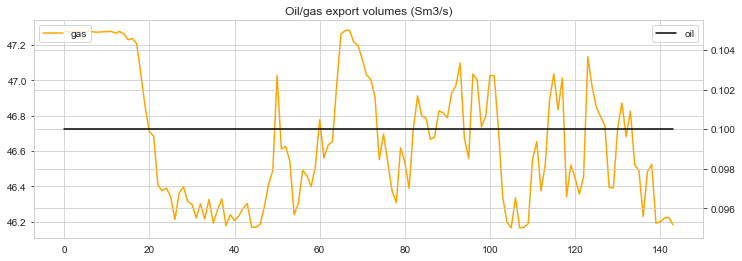

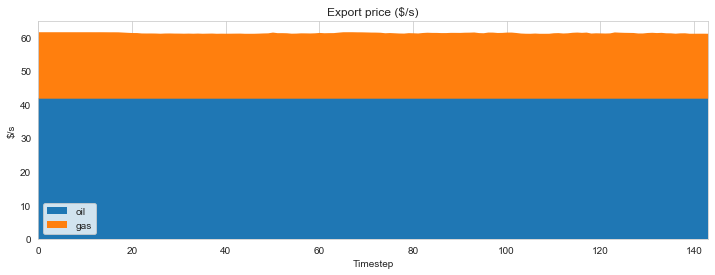

In [24]:
plt.figure(figsize=(12,4))
ax=plt.gca()
labels=[]
df=mc._dfDevicePower.unstack(0)[['ex_g','ex_o']]
ax.plot(df['ex_g'],label='gas',color='orange')
ax.legend(loc='upper left')
ax2=ax.twinx()
ax2.plot(df['ex_o'],label='oil',color='black')
ax2.legend(loc='upper right')
plt.title("Oil/gas export volumes (Sm3/s)")

#    ax.legend(labels,loc='lower left', bbox_to_anchor =(1.01,0),
#              frameon=False)
#plt.savefig(outpath+"export.png",bbox_inches = 'tight')

plots.plot_ExportRevenue(mc)

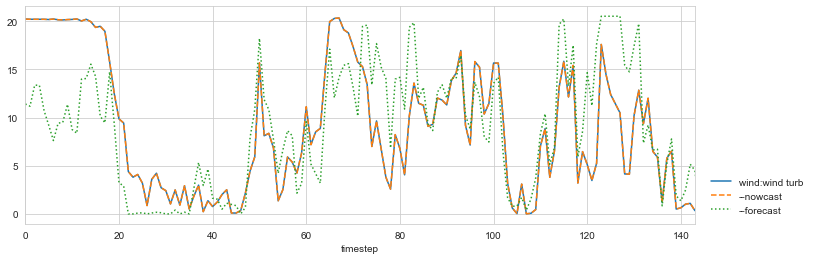

In [25]:
if 'wind' in mc.instance.setDevice:
    plots.plot_deviceprofile(mc,devs=['wind'],profiles=profiles,
                             filename=None)#outpath+"WT_opt.png")

In [26]:
if 'battery' in mc.instance.setDevice:
    plots.plot_devicePowerEnergy(mc,'battery',
                                 filename=None)#outpath+"battery_opt.png")
    multicarrier.Plots.plotDevicePowerLastOptimisation1(mc,device='battery',
                filename=None)#outpath+"lastopt_battery.png")

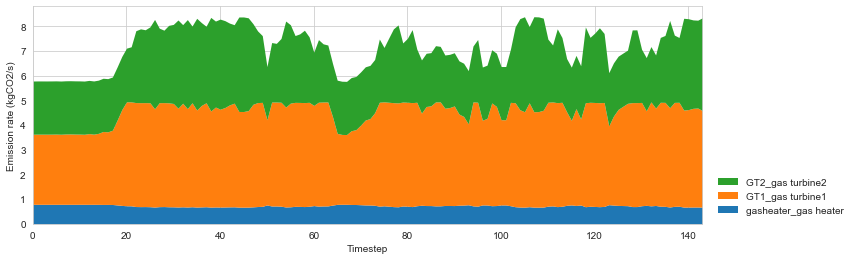

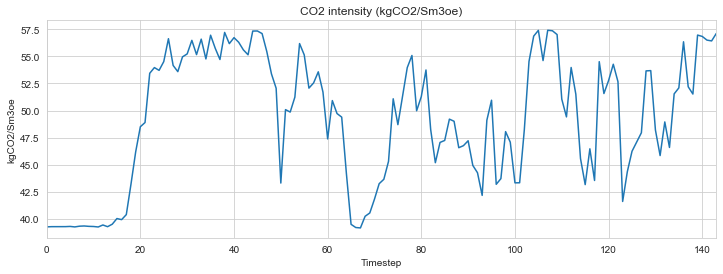

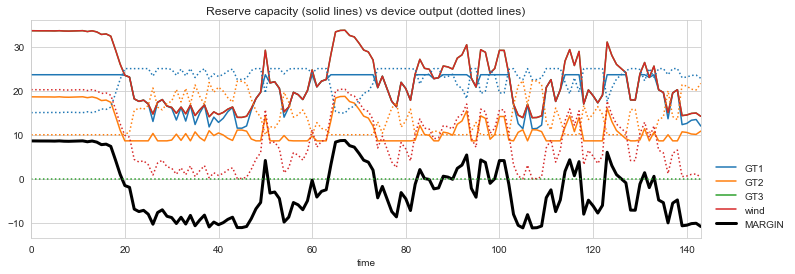

In [42]:
plots.plot_CO2rate_per_dev(mc,reverseLegend=True)#,filename=outpath+"co2rate_opt.png")
plots.plot_CO2_intensity(mc)#,filename=outpath+"co2intensity_opt.png")
plots.plotElReserve(mc)#,filename=outpath+"elReserve.png")


p=plots.plot_df(mc._dfDevicePower,id_var="device",filename=None,#outpath+"plotly.html",
              title="Device Power",ylabel="Power (MW)")

# Last optimisisation (results for a horizon)
#multicarrier.Plots.plotDeviceSumPowerLastOptimisation(instance,
#                                                      filename=outpath+"lastopt_devsum_el.png")
#multicarrier.Plots.plotEmissionRateLastOptimisation(instance,filename=outpath+"lastopt_co2out.png")


